# Transformers under the hood
- Following the tutorial from pytorch to obtain the trained model (Predicting next word, same length as input size)
- Reimplementing the forward passes of encoding, transformer encoder layer and multihead self attention
- Comparing the output of my forward implementations with the model as sanity checks
- Useful for understanding how the matrix operations (and tensor shapes) suppose work

# 1. Pytorch's Tutorial
https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## 1.1. Model

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## 1.2. Data

In [43]:
import io
import torch
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
# test_filepath, valid_filepath, train_filepath = extract_archive(download_from_url(url, "/data/datasets/wikitext-2-v1.zip"))
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, iter(io.open(train_filepath, encoding="utf8"))))

def data_process(raw_text_iter):
    data = [
        torch.tensor([vocab[token] for token in tokenizer(item)],dtype=torch.long) 
        for item in raw_text_iter
    ]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

36718lines [00:01, 32408.33lines/s]


In [105]:
# String to Ints
inv_vocab = {v:k for k,v in vocab.stoi.items()}
s = "I am a potato"
t = [vocab[x] for x in tokenizer(s)]
print(s)
print(t)
print([inv_vocab[x] for x in t])

I am a potato
[65, 1732, 9, 15999]
['i', 'am', 'a', 'potato']


In [55]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [136]:
batch = get_batch(train_data, 0)
# The sequences are columns (=batch_size), while the tokens are rows (=bptt)
print("shape X (seq_len x batch_size):", batch[0].shape)

# Example sequence (col 0)
print("X0:", "'" + " ".join(str(inv_vocab[x.item()]) for x in batch[0][:, 0]) + "'")

# Targets are flattened, but their structure was also seq_len x batch size.
print("shape y (seq_len * batch_size):", batch[1].shape)

# To print the targets for a sequence (the sequence shifted), which was originally as a column, one must skip by batchsize
print("y0:", "'" + " ".join(str(inv_vocab[x.item()]) for x in batch[1][0::batch_size]) + "'")

shape X (seq_len x batch_size): torch.Size([35, 20])
X0: '= valkyria chronicles iii = senjō no valkyria 3 999 chronicles ( japanese 戦場のヴァルキュリア3 , lit . valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is'
shape y (seq_len * batch_size): torch.Size([700])
y0: 'valkyria chronicles iii = senjō no valkyria 3 999 chronicles ( japanese 戦場のヴァルキュリア3 , lit . valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is a'


## 1.3. Training

In [138]:
ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [139]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [140]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 13.90 | loss  8.24 | ppl  3784.98
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 11.86 | loss  6.91 | ppl  1005.75
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 11.87 | loss  6.46 | ppl   640.40
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 11.87 | loss  6.31 | ppl   551.57
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 11.98 | loss  6.20 | ppl   492.49
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 11.88 | loss  6.17 | ppl   475.80
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 11.86 | loss  6.12 | ppl   456.28
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 11.87 | loss  6.11 | ppl   450.54
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 11.94 | loss  6.03 | ppl   417.41
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 11.91 | loss  6.02 | ppl   412.42
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 11.93 | loss  5.91 | ppl   367.42
| epoch   1 |  2400/ 

# 2. Forward Walkthrough
- Looking into embedding, encoding layers and self attention
- First calling forward of the modules, then reimplementing the operations using the existing parameters
- Model is in eval mode, so dropout is disabled

In [831]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

seq_len = bptt

In [188]:
data, targets = get_batch(train_data, 0)
src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
output = model(data, src_mask)

print("data shape", data.shape)
print("output.shape", output.shape)

data shape torch.Size([35, 20])
output.shape torch.Size([35, 20, 28786])


In [349]:
model.training

False

## 2.1 Encoding

In [189]:
model.encoder

Embedding(28786, 200)

In [190]:
src_enc = model.encoder(data) * math.sqrt(model.ninp)
src_enc.shape

torch.Size([35, 20, 200])

In [191]:
src_pos = model.pos_encoder(src_enc)

In [283]:
# similarity post positional encoding
torch.cosine_similarity(src_enc[0,0], src_pos[0, 0], dim=0).item()

0.9857063889503479

## 2.2 Transformer Encoder Layer
- Each transformation works on a per-token level
- Linear can accept tensors of any shape and will apply the transformaton on only the last dimension
- It means that the transformation of a token does not depend on other tokens from the same sequence or batch (technically it does because of softmax, but conceptually it's just an importance score)
- The preservation of the token concept is necessary for attention to have multiple layers. If one would have a linear layer convolving all tokens then it wouldnt be clear what attention would even mean.

In [186]:
layer = model.transformer_encoder.layers[0]
layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): Linear(in_features=200, out_features=200, bias=True)
  )
  (linear1): Linear(in_features=200, out_features=200, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=200, out_features=200, bias=True)
  (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [196]:
src = src_pos

sub1 = layer.self_attn(src, src, src, attn_mask=src_mask)[0]
sub1 = layer.norm1(src + layer.dropout1(sub1))

sub2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(sub1))))
sub2 = layer.norm2(sub1 + layer.dropout2(sub2))

In [197]:
sub1.shape

torch.Size([35, 20, 200])

In [198]:
sub2.shape

torch.Size([35, 20, 200])

In [282]:
torch.cosine_similarity(sub1[0,0], sub2[0, 0], dim=0).item()

0.5762916803359985

## 2.3 Self-Attention

$$Attention(Q,K,V) = softmax(\frac{QK^⊤}{\sqrt n})V$$


- q, k, v parameters are stored in one linear layer. splitting pre or post op yields same result
- torch linear works on any shapes as long as the last dim matches the linear dim. it applies the linear projection on each element independently, similar to how it is applied to each observation in a batch.
- similarly, torch matmul in 3 dimensions works by "batching" the multiplications on the first dimension. [N, A, B] x [N, B, C] = [N, A, C]
- Mask is added, not multiplied (as one usually does with masks) to avoid the inversion of -inf by negative dot products
- The scaling factor is based on the encoding size of token, not the number of tokens in the sequence as the magnitude of the dot product changes the more dimensions it has. The dimensionality is dependent on the nr of heads.
- Each head operates on a different subspace of the embedding. Each head has access to all tokens in sequence, but focuses on a different part of the embedding. If the embedding dim is 200 and we have two heads, then the first head will operate on the first 100 values of the embedding.
- When computing the attention matrix we want to obtain a distance matrix between all tokens (35 * 35) for each sequence in the batch (20) across the embedding (200 / n_heads). The matmul op receives the batch as the first dimension. Attetion matrix [batch_size, n_tokens, n_tokens] = [batch_size, n_tokens, embedding] x [batch_size, embedding, n_tokens]
- The attention weights/matrix is averaged over all heads to obtain a visualisation
- The attention output is computed per head and concatenated only before feeding it into the output linear layer
- Will be plotting the attention matrix of the first sequence only

### 2.3.1 Auto Forward
- attention layer produces two outputs: the embedding and the attention matrix

In [214]:
attention = model.transformer_encoder.layers[0].self_attn
attention

MultiheadAttention(
  (out_proj): Linear(in_features=200, out_features=200, bias=True)
)

In [550]:
attention_out, attention_matrix = attention(src_pos, src_pos, src_pos, attn_mask=src_mask)
attention_out.shape, attention_matrix.shape

(torch.Size([35, 20, 200]), torch.Size([20, 35, 35]))

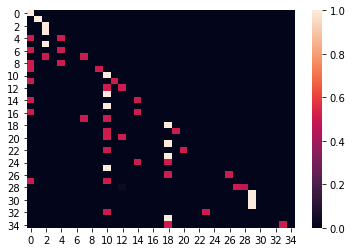

In [551]:
sns.heatmap(attention_matrix[0].detach().cpu()) # the first sequence

### 2.3.2 Manual Forward with 1 Head
- Pretending it has one head
- Embedding size = 200
- batch size = 20
- Sequence length = 35
- scaling factor is $\sqrt 200$

In [864]:
# Splitting the linear layer for conceptual simplicity
q_w, k_w, v_w = attention.in_proj_weight.chunk(3)
q_b, k_b, v_b = attention.in_proj_bias.chunk(3)

q = torch.matmul(src, q_w.T) + q_b
k = torch.matmul(src, k_w.T) + k_b
v = torch.matmul(src, v_w.T) + v_b

In [833]:
q.shape, k.shape, v.shape

(torch.Size([35, 20, 200]),
 torch.Size([35, 20, 200]),
 torch.Size([35, 20, 200]))

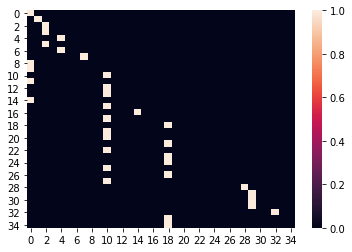

In [834]:
# We want a similarity matrix for each sequence (dim0=20) between all tokens (35 * 35) across embeddings. [n_tokens, embd] x [embd, n_tokens] 
m = torch.matmul(q.permute(1, 0, 2), k.permute(1, 2, 0))
m = (m + src_mask) / emsize ** .5
m = m.softmax(dim=-1)
sns.heatmap(m.detach().cpu()[0])

In [850]:
out = attention.out_proj(        
    torch.matmul(m, v.transpose(0, 1)) # [20, 35, 35] x [20, 35, 200]
    .transpose(0, 1)   # back to [seq_len, batch_size, emsize]
)
out.shape

torch.Size([35, 20, 200])

### 2.3.2 Manual with 2 Heads
- Split the embedding dimension in two (head_emsize=100)
- Scaling factor is now $\sqrt100$
- Final attention matrix is the average of the head attention matrices

In [865]:
head_emsize = emsize // nhead
print(f"Orig Embedding size: {emsize}, n_heads: {nhead}, embedding size per head: {head_emsize}")

Orig Embedding size: 200, n_heads: 2, embedding size per head: 100


In [866]:
q0, k0, v0 = q[:,:,:head_emsize], k[:,:,:head_emsize], v[:,:,:head_emsize]
q1, k1, v1 = q[:,:,head_emsize:], k[:,:,head_emsize:], v[:,:,head_emsize:]

q0.shape

torch.Size([35, 20, 100])

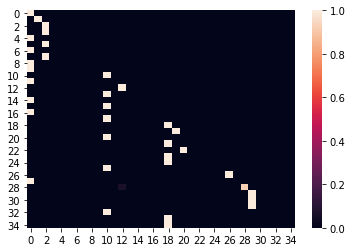

In [867]:
# Attention matrix head0
m0 = torch.matmul(q0.permute(1, 0, 2), k0.permute(1, 2, 0))
m0 = (m0 + src_mask) / head_emsize ** .5
m0 = m0.softmax(dim=-1)
sns.heatmap(m0.detach().cpu()[0])

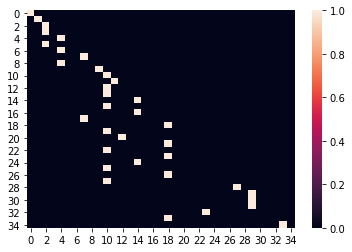

In [868]:
# Attention matrix head1
m1 = torch.matmul(q1.permute(1, 0, 2), k1.permute(1, 2, 0))
m1 = (m1 + src_mask) / head_emsize ** .5
m1 = m1.softmax(dim=-1)
sns.heatmap(m1.detach().cpu()[0])

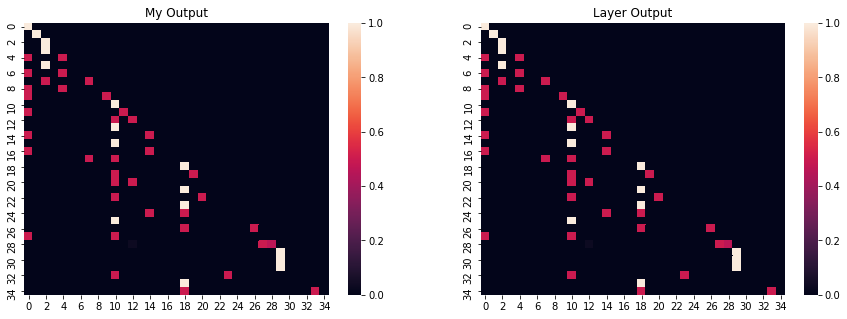

In [869]:
# Average attention matrices (just for viz)
m = (m0 + m1) / 2

# plot side by side with layer output
f, axarr = plt.subplots(1, 2, figsize=[15, 5])
axarr[0].set_title("My Output")
sns.heatmap(m.detach().cpu()[0], ax=axarr[0])
axarr[1].set_title("Layer Output")
sns.heatmap(attention_matrix.detach().cpu()[0], ax=axarr[1])


In [870]:
# Test that it's the same as the layer output. Rounding erros are quite high.
np.array_equal(attention_matrix.detach().cpu().numpy().round(4), m.detach().cpu().numpy().round(4))

True

In [895]:
# ... continue with computing the output of the layer

# multiply the attention matrix with the value matrix for each head and concatenate the same way we split initially (on the embedding dimension)
my_attention_out = torch.cat([
    torch.matmul(m0, v0.permute(1, 0, 2)), # [batch_size, seq_len, embd]
    torch.matmul(m1, v1.permute(1, 0, 2))
], dim=-1)
# my_attention_out.shape # [20, 35, 200]


# permute again (swap batch_size and seq_len) and feed to final linear projection
my_attention_out = my_attention_out.transpose(0, 1)
my_attention_out = attention.out_proj(my_attention_out)
my_attention_out.shape

torch.Size([35, 20, 200])

In [926]:
# Compare with benchmark layer output
np.array_equal(my_attention_out.detach().cpu().numpy().round(4), attention_out.detach().cpu().numpy().round(4))

False

In [928]:
# Visually inspect to find difference
print(my_attention_out[1])

print(attention_out[1])
# seems fine, might be rounding error

tensor([[ 0.3610,  0.0270,  0.8850,  ...,  0.0983, -0.1146, -0.4112],
        [-1.2647, -1.0522, -0.7382,  ...,  0.4196, -1.3759,  1.1311],
        [ 0.6605,  0.4115, -0.0596,  ..., -0.1676,  0.5545, -1.4234],
        ...,
        [ 0.1075,  1.0240, -0.0183,  ..., -0.0478, -1.0747, -1.0681],
        [ 1.3460,  1.2767, -1.9809,  ..., -0.5395, -0.6522, -0.5362],
        [-0.6610, -0.0349, -0.0958,  ...,  0.0378, -0.1432,  0.3121]],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([[ 0.3610,  0.0270,  0.8850,  ...,  0.0983, -0.1146, -0.4112],
        [-1.2647, -1.0522, -0.7382,  ...,  0.4196, -1.3759,  1.1311],
        [ 0.6605,  0.4115, -0.0596,  ..., -0.1676,  0.5545, -1.4234],
        ...,
        [ 0.1075,  1.0240, -0.0183,  ..., -0.0478, -1.0747, -1.0681],
        [ 1.3460,  1.2767, -1.9809,  ..., -0.5395, -0.6522, -0.5363],
        [-0.6610, -0.0349, -0.0958,  ...,  0.0378, -0.1432,  0.3121]],
       device='cuda:0', grad_fn=<SelectBackward>)


In [934]:
# Round at different decimals to see how large the rounding errors are
decimals = [4, 3, 2, 1]

for decimal in decimals:
    equal = np.array_equal(my_attention_out.detach().cpu().numpy().round(decimal), attention_out.detach().cpu().numpy().round(decimal))
    print(f"for {decimal} decimals results are equal: {equal}")
    
# @_@

for 4 decimals results are equal: False
for 3 decimals results are equal: False
for 2 decimals results are equal: False
for 1 decimals results are equal: True


# Torch source code multi_head_attention_forward
- as a reference because the foldings/reshaping used to optimise attention are hard to digest
- This implementation, using bmm and other under the hood directives, produces siginificant rounding differences in comparison with the naive approach

In [935]:
src_len = tgt_len = 35
bsz = 20
num_heads = 2
head_dim = 100
embed_dim = 200
attn_mask = src_mask


q, k, v = torch.nn.functional.linear(src, attention.in_proj_weight, attention.in_proj_bias).chunk(3, dim=-1)
q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

scaling = float(head_dim) ** -0.5
q = q * scaling

attn_output_weights = torch.bmm(q, k.transpose(1, 2))
attn_output_weights += attn_mask
attn_output_weights = attn_output_weights.softmax(dim=-1)
attn_output_weights = torch.nn.functional.dropout(attn_output_weights, p=attention.dropout, training=attention.training)


attn_output = torch.bmm(attn_output_weights, v)
attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
attn_output = torch.nn.functional.linear(attn_output, attention.out_proj.weight, attention.out_proj.bias)


attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
attn_output_weights = attn_output_weights.sum(dim=1) / num_heads

In [942]:
# it's the same implementation so this should be identical
np.array_equal(attn_output.detach().cpu().numpy().round(3), attention_out.detach().cpu().numpy().round(3))

True